In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from glob import glob
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
# From https://www.kaggle.com/elvinj1203/resnet50-84-test-acc
data=pd.read_csv("../data/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [3]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.2, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [4]:
#Oversampling
ros = RandomOverSampler(sampling_strategy='not majority',
                    random_state=42)
X_upsampled, Y_upsampled = ros.fit_resample(X_train, y_train)

In [5]:
Y_upsampled.dx.value_counts()

df       4050
nv       4050
akiec    4050
mel      4050
bcc      4050
vasc     4050
bkl      4050
Name: dx, dtype: int64

In [6]:
#train=pd.concat([X_train,y_train],axis=1)
train_upsampled = pd.concat([X_upsampled, Y_upsampled], axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [7]:
"""image_full_name 	lesion_id 	dx
482 	ISIC_0030346.jpg 	HAM_0005146 	bkl
7123 	ISIC_0032007.jpg 	HAM_0007477 	nv
6581 	ISIC_0030449.jpg 	HAM_0007071 	nv
6991 	ISIC_0025812.jpg 	HAM_0001767 	nv
6333 	ISIC_0027587.jpg 	HAM_0003907 	nv"""

'image_full_name \tlesion_id \tdx\n482 \tISIC_0030346.jpg \tHAM_0005146 \tbkl\n7123 \tISIC_0032007.jpg \tHAM_0007477 \tnv\n6581 \tISIC_0030449.jpg \tHAM_0007071 \tnv\n6991 \tISIC_0025812.jpg \tHAM_0001767 \tnv\n6333 \tISIC_0027587.jpg \tHAM_0003907 \tnv'

In [8]:
val.dx.value_counts()

nv       1317
bkl       243
mel       230
bcc       111
akiec      57
vasc       27
df         18
Name: dx, dtype: int64

In [9]:
test.dx.value_counts()

nv       1338
bkl       228
mel       226
bcc        93
akiec      69
df         28
vasc       21
Name: dx, dtype: int64

In [10]:
image_path = '../data/HAM10000'

In [11]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
# horizontal_flip=True to flip images randomly
image_generator = ImageDataGenerator(
    rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE_128 = (128, 128)
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# !!!! This train_generator is oversampled train
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_upsampled,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

Found 28350 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

In [13]:
def MobileNetV2_frozen(img_size=None):
  # Import the mobilenetV2 model and discards the last 1000 neuron layer.
    base_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=img_size)
    print("Number of layers in the base model: ", len(base_model.layers))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
  # Dense = FullyConnected
    x = Dense(1024,activation='relu')(x) 
  # Final layer with softmax activation
    pred_layer = Dense(7, activation='softmax')(x) 

    model = Model(inputs=base_model.input,outputs=pred_layer)
    return model


In [14]:
def VGG16_frozen(img_size=None):
    base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=img_size)
    print('Number of layers of the base model: ', len(base_model.layers))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    
    prediction = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=prediction)
    return model

In [73]:
model = VGG16_frozen((128,128,3))
model.summary()

# Adam learning rate
#opt = Adam(lr=0.001)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

Number of layers of the base model:  19
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPoo

In [74]:
vgg16_frozen_path = "vgg16_frozen.ckpt"
vgg16_frozen_dir = '/output/working/' + vgg16_frozen_path

In [75]:
saveCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=vgg16_frozen_dir, 
    verbose=1, 
    save_weights_only=True,
    period=5)

In [17]:
"""mobileNetV2_frozen_path = "mobileNetV2_frozen.ckpt"
mobileNetV2_frozen_dir = '/output/working/' + mobileNetV2_frozen_path

mobileNetV2_trainable_path = "mobileNetV2_trainable.ckpt"
mobileNetV2_trainable_dir = '/output/working/' + mobileNetV2_trainable_path"""

In [18]:
saveCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=mobileNetV2_frozen_dir, 
    verbose=1, 
    save_weights_only=True,
    period=5)

saveCheckpointTrainable = tf.keras.callbacks.ModelCheckpoint(
    filepath=mobileNetV2_trainable_dir, 
    verbose=1, 
    save_weights_only=True,
    period=5)

In [80]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[saveCheckpoint]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 886 steps, validate for 63 steps
Epoch 1/50
886/886 [==============================] - 299s 338ms/step - loss: 0.5906 - tp: 20120.0000 - fp: 3402.0000 - tn: 166698.0000 - fn: 8230.0000 - accuracy: 0.9414 - precision: 0.8554 - recall: 0.7097 - auc: 0.9713 - val_loss: 0.9685 - val_tp: 1207.0000 - val_fp: 496.0000 - val_tn: 11522.0000 - val_fn: 796.0000 - val_accuracy: 0.9079 - val_precision: 0.7087 - val_recall: 0.6026 - val_auc: 0.9281
Epoch 2/50
885/886 [============================>.] - ETA: 0s - loss: 0.5119 - tp: 21388.0000 - fp: 3095.0000 - tn: 166813.0000 - fn: 6930.0000 - accuracy: 0.9494 - precision: 0.8736 - recall: 0.7553 - auc: 0.9783
Epoch 00002: saving model to /output/working/vgg16_frozen.ckpt
886/886 [==============================] - 301s 339ms/step - loss: 0.5118 - tp: 21415.0000 - fp: 3099.0000 - tn: 167001.0000 - fn: 6935.0000 - accuracy: 0.9494 - precision: 0.8736 - recall: 0.7554 - auc: 0.9783 - val_loss: 0

In [23]:
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    precision = history.history['precision']
    val_precision = history.history['val_precision']

    recall = history.history['recall']
    val_recall = history.history['val_recall']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(precision, label='Training Precision')
    plt.plot(val_precision, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Precision')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Recall')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

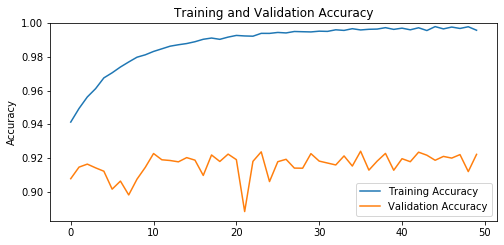

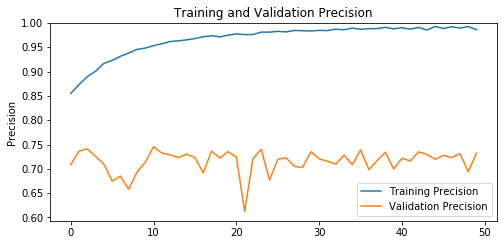

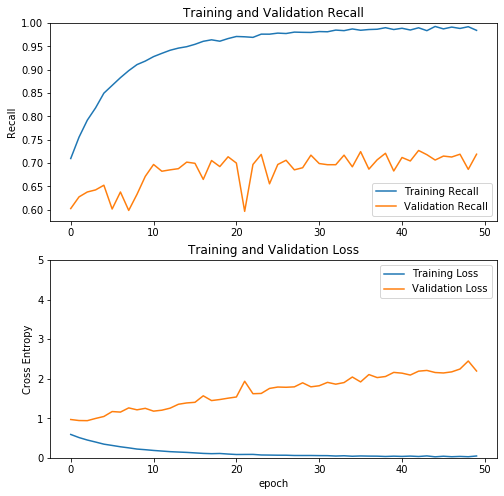

In [85]:
history_plot(history)

In [96]:
df = pd.DataFrame(history.history)
df.to_csv('./output/evaluation_value.csv')

In [86]:
model.evaluate(test_generator)

  ...
    to  
  ['...']
63/63 [==============================] - 21s 331ms/step - loss: 1.9660 - tp: 1446.0000 - fp: 522.0000 - tn: 11496.0000 - fn: 557.0000 - accuracy: 0.9230 - precision: 0.7348 - recall: 0.7219 - auc: 0.9069


[1.9659682398750669,
 1446.0,
 522.0,
 11496.0,
 557.0,
 0.923044,
 0.7347561,
 0.72191715,
 0.90693414]

In [99]:
model.save('../models/vgg16_50_epochs_w_0_9985_accuracy.h5')

In [15]:
def ResNet50_frozen(img_size=None):
    base_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=img_size)
    print('Number of layers of the base model: ', len(base_model.layers))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    
    prediction = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=prediction)
    return model

In [16]:
model = ResNet50_frozen((128,128,3))
model.summary()

# Adam learning rate
#opt = Adam(lr=0.001)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

Number of layers of the base model:  175
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_____________________________________________________

In [17]:
resnet50_frozen_path = "resnet50_frozen.ckpt"
resnet50_frozen_dir = '/output/working/' + resnet50_frozen_path

In [18]:
saveCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=resnet50_frozen_dir, 
    verbose=1, 
    save_weights_only=True,
    period=5)

In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[saveCheckpoint]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 886 steps, validate for 63 steps
Epoch 1/50
886/886 [==============================] - 321s 363ms/step - loss: 0.4354 - tp: 23057.0000 - fp: 2823.0000 - tn: 167277.0000 - fn: 5293.0000 - accuracy: 0.9591 - precision: 0.8909 - recall: 0.8133 - auc: 0.9827 - val_loss: 1.8427 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 12018.0000 - val_fn: 2003.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6206
Epoch 2/50
886/886 [==============================] - 327s 370ms/step - loss: 0.1113 - tp: 27137.0000 - fp: 923.0000 - tn: 169177.0000 - fn: 1213.0000 - accuracy: 0.9892 - precision: 0.9671 - recall: 0.9572 - auc: 0.9985 - val_loss: 1.7521 - val_tp: 1317.0000 - val_fp: 686.0000 - val_tn: 11332.0000 - val_fn: 686.0000 - val_accuracy: 0.9021 - val_precision: 0.6575 - val_recall: 0.6575 - val_auc: 0.8175
Epoch 3/50
886/886 [==============================] - 312s 352ms/step - loss: 0.0666

In [20]:
df = pd.DataFrame(history.history)
df.to_csv('./output/111evaluation_value.csv')

In [21]:
model.save('../models/111111vgg16_50_epochs_w_0_9985_accuracy.h5')

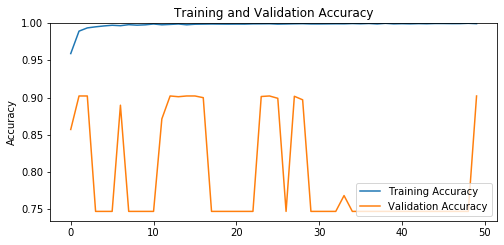

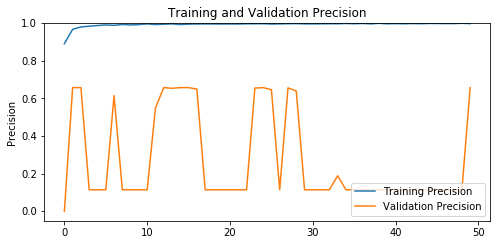

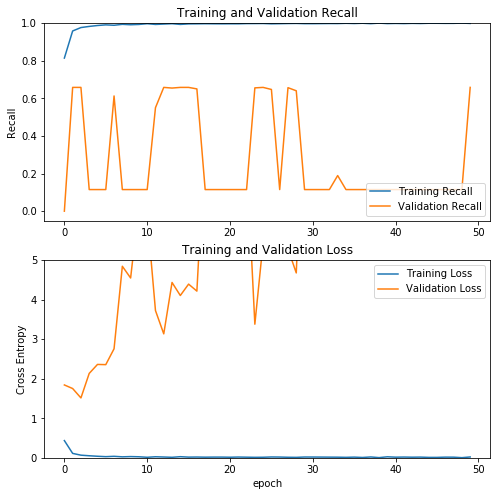

In [24]:
history_plot(history)